In [355]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

import lightgbm as ltb

import seaborn as sns

from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from datetime import datetime, date
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [356]:
train_df = pd.read_csv("../Datasets/new_df.csv")
test_df = pd.read_csv("../Datasets/test.csv")
train_df["date"] = pd.to_datetime(train_df["date"])

In [357]:
def process(row):
    year = int(str(row)[:4])
    week = int(str(row)[4:])
    new_date = date.fromisocalendar(year, week, 1)
    return new_date

train_df['dt_year_week'] = train_df['year_week'].apply(process)

df_forecast = train_df.loc[:, ("dt_year_week", "product_number",  "inventory_units")]
df_forecast["dt_year_week"] = pd.to_datetime(df_forecast["dt_year_week"])
df = [x for _, x in df_forecast.groupby('product_number')]

In [358]:
scaler_inventory_units = MinMaxScaler()
df[0][['inventory_units']] = scaler_inventory_units.fit_transform(df[0][['inventory_units']])

In [359]:
df_train = df[0][['dt_year_week', 'inventory_units']]
df_train = df_train.dropna()

df_train = df_train.set_index('dt_year_week')
train, val = df_train.iloc[:90, :], df_train.iloc[90:, :]

In [360]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [361]:
warnings.filterwarnings('ignore')

minim = 1000000000
model = ARIMA(train, order=(2,2,0))
model_fit = model.fit()
print(model_fit.summary())
output = model_fit.forecast(len(val))

                               SARIMAX Results                                
Dep. Variable:        inventory_units   No. Observations:                   90
Model:                 ARIMA(2, 2, 0)   Log Likelihood                  63.379
Date:                Sat, 13 May 2023   AIC                           -120.759
Time:                        21:47:17   BIC                           -113.327
Sample:                             0   HQIC                          -117.765
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3552      0.082     -4.337      0.000      -0.516      -0.195
ar.L2          0.0110      0.101      0.109      0.913      -0.187       0.209
sigma2         0.0138      0.002      8.442      0.0

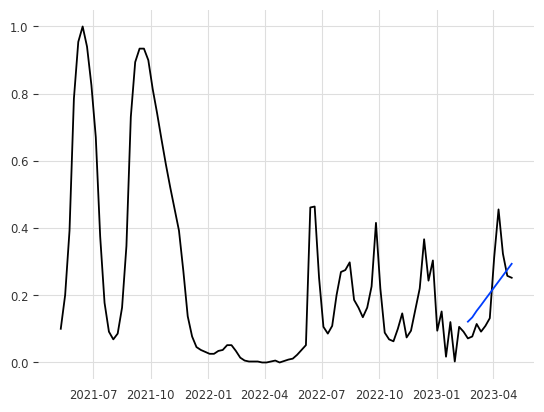

In [362]:
import matplotlib.pyplot as plt

plt.plot(df_train.index, df_train.inventory_units)
plt.plot(val.index, output)